### 0719 DOING frame consistency

## ELAN Evaluation metrics (Dim delta, depth, alpha, Dim consistency)

In [ ]:
from library.ron_utils import *
import matplotlib.pyplot as plt
from library.ron_utils import iou_2d, TrackingObject
from ELAN_label_trackID import tracking_obj_by_labels
from ELAN_EVAL import evaluation

'''
cam_to_img = np.array([
        [ 1.418667e+03, 0.000000e+00, 6.4e+02,0],
        [ 0.000000e+00, 1.418667e+03, 3.6e+02,0],
        [ 0.000000e+00, 0.000000e+00, 1.000000e+00,0]])
'''

def ELAN_eval_metrics(result_root):
    valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
    dim_GT = list()
    dim_ELAN = list()
    depth_GT = list()
    depth_ELAN = list()
    alpha_GT = list()
    alpha_ELAN = list()
    #set_ = set()
    for id_ in valset:
        gt_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label_obj/{id_}.txt').readlines()]
        gt_objects = [TrackingObject(line) for line in gt_lines if line.split()[0].lower()=='car']
        
        for obj in gt_objects:
            #set_.add(obj.id)
            dim_GT.append(obj.dims[0])
            depth_GT.append(obj.locs[0][2])
            alpha_GT.append(obj.alphas[0])
            
        pred_lines = [x.strip() for x in open(f'{result_root}/label_2/{id_}.txt').readlines()]
        pred_objects = [TrackingObject(line) for line in pred_lines if line.split()[0].lower()=='car']
        for obj in pred_objects:
            dim_ELAN.append(obj.dims[0])
            depth_ELAN.append(obj.locs[0][2])
            alpha_ELAN.append(obj.alphas[0])
    
    #print('OBJECT NUM', len(set_))
    #print(set_)
    dim_GT = np.array(dim_GT)
    dim_ELAN = np.array(dim_ELAN)
    depth_GT = np.array(depth_GT)
    depth_ELAN = np.array(depth_ELAN)
    alpha_GT = np.array(alpha_GT)
    alpha_ELAN = np.array(alpha_ELAN)

    depth_diff = depth_GT-depth_ELAN
    alpha_diff = np.cos(alpha_GT - alpha_ELAN)
    dim_diff = np.mean(abs(dim_GT-dim_ELAN), axis=0)
    print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
    
    print(f'[Alpha diff] abs_mean: {1-alpha_diff.mean():.4f}')
    plt.hist(alpha_diff)
    plt.show()
    print(f'[Depth diff] abs_mean: {abs(depth_diff).mean():.4f}')
    print('[Depth error]')
    box_depth_error_calculation(depth_GT, depth_ELAN, 5)

In [ ]:
# BL_IMAGENET BL_ELAN
# video_IMAGENET video_ELAN
date = '0720/'
N0_folders = ['BL_B4_N0', 'V_dim_B4_N0', 'V_alpha_B4_N0', 'V_dim_alpha_B4_N0']
N1_folders = ['BL_B4_N1', 'V_dim_B4_N1', 'V_alpha_B4_N1', 'V_dim_alpha_B4_N1']
is_group = False
for f in N0_folders:
    tmp_f = date + f
    if is_group:
        tmp_f += '_G_W10'
    print(f'========{tmp_f}========')
    ELAN_eval_metrics(tmp_f)
    print()


## visualize bad results

In [ ]:
import matplotlib.pyplot as plt
valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
dim_GT = list()
dim_ELAN = list()
alpha_GT = list()
alpha_ELAN = list()

result_root = 'V_alpha_B4_N0'


for id_ in valset:
    gt_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label_obj/{id_}.txt').readlines()]
    gt_objects = [TrackingObject(line) for line in gt_lines if line.split()[0].lower()=='car']
    pred_lines = [x.strip() for x in open(f'{result_root}/label_2/{id_}.txt').readlines()]
    pred_objects = [TrackingObject(line) for line in pred_lines if line.split()[0].lower()=='car']
    image = cv2.cvtColor(cv2.imread(f'Elan_3d_box/image_2/{id_}.png'), cv2.COLOR_BGR2RGB)
    for i in range(len(gt_objects)):
        gt = gt_objects[i]
        pred = pred_objects[i]
        
        alpha_GT.append(gt.alphas[0])
        alpha_ELAN.append(pred.alphas[0])
        if np.cos(gt.alphas[0] - pred.alphas[0]) < 0.8:
            print(f'{id_}:GT:{gt.alphas[0]}, REG:{pred.alphas[0]}')
            gt_crop = image[gt.box2d[0][1]:gt.box2d[1][1]+1, gt.box2d[0][0]:gt.box2d[1][0]+1]
            pred_crop = image[pred.box2d[0][1]:pred.box2d[1][1]+1, pred.box2d[0][0]:pred.box2d[1][0]+1]
            plt.imshow(pred_crop)
            plt.show()

alpha_GT = np.array(alpha_GT)
alpha_ELAN = np.array(alpha_ELAN)
alpha_diff = np.cos(alpha_GT-alpha_ELAN)
print(1-alpha_diff.mean())

## Eval result : improvement of objects

In [ ]:
import glob
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
val_images = sorted(glob.glob('Elan_3d_box/image_2/*.png'))[-1*len(valset):] 
GT_labels = sorted(glob.glob('Elan_3d_box/renew_label/*.txt'))[-1*len(valset):]

# video_ELAN video_IMAGENET
V_labels = sorted(glob.glob('video_ELAN/label_2/*.txt'))[-1*len(valset):]
# BL_ELAN BL_IMAGENET
BL_labels = sorted(glob.glob('BL_ELAN/label_2/*.txt'))[-1*len(valset):]
assert len(valset) == len(V_labels), 'video_label length diff'
assert len(valset) == len(BL_labels), 'BL_label length diff'

GT_tracking_dict = tracking_obj_by_labels(GT_labels, val_images, WRITE_FILE=False)
V_tracking_dict = tracking_obj_by_labels(V_labels, val_images, WRITE_FILE=False)
BL_tracking_dict = tracking_obj_by_labels(BL_labels, val_images, WRITE_FILE=False)

In [ ]:
other_count = 0
c = 0
dim_GT_1 = list()
dim_V_1 = list()
dim_BL_1 = list()

dim_GT_f = list()
dim_V_f = list()
dim_BL_f = list()

classes = ['motor', 'bus', 'car']
for key in GT_tracking_dict.keys():
    GT_obj = GT_tracking_dict[key]
    V_obj = V_tracking_dict[key]
    BL_obj = BL_tracking_dict[key]
    if GT_obj.class_.lower() != 'car':
        other_count += 1
        continue
    if (V_obj.box2d != BL_obj.box2d).all() or (V_obj.box2d != GT_obj.box2d).all() or (GT_obj.box2d != BL_obj.box2d).all():
        print('Box 2D diff:', key)
        break
        
    if len(GT_obj.frames) == 1:
        dim_GT_1.append(GT_obj.dims[0])
        dim_V_1.append(V_obj.dims[0])
        dim_BL_1.append(BL_obj.dims[0])
    else:
        dim_GT_f += GT_obj.dims
        dim_V_f += V_obj.dims
        dim_BL_f += BL_obj.dims
    c += 1 

In [ ]:
dim_GT_1 = np.array(dim_GT_1)
dim_V_1 = np.array(dim_V_1)
dim_BL_1 = np.array(dim_BL_1)
dim_GT_f = np.array(dim_GT_f)
dim_V_f = np.array(dim_V_f)
dim_BL_f = np.array(dim_BL_f)

V_dim_diff_1 = np.mean(abs(dim_GT_1 - dim_V_1), axis=0)
BL_dim_diff_1 = np.mean(abs(dim_GT_1 - dim_BL_1), axis=0)
print('1 frame')

print(BL_dim_diff_1)
print(V_dim_diff_1)

V_dim_diff_f = np.mean(abs(dim_GT_f - dim_V_f), axis=0)
BL_dim_diff_f = np.mean(abs(dim_GT_f - dim_BL_f), axis=0)
print('multi- frame')
print(BL_dim_diff_f)
print(V_dim_diff_f)

In [ ]:
V_dim_diff_1 = abs(dim_GT_1 - dim_V_1)
BL_dim_diff_1 = abs(dim_GT_1 - dim_BL_1)
V_dim_diff_f = abs(dim_GT_f - dim_V_f)
BL_dim_diff_f = abs(dim_GT_f - dim_BL_f)

BL = np.concatenate((BL_dim_diff_1, BL_dim_diff_f))
print(np.mean(BL, axis=0))

V = np.concatenate((V_dim_diff_1, V_dim_diff_f))
print(np.mean(V, axis=0))

# 0911 KITTI Tracking Dataset

In [ ]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
from torch_lib.KITTI_Dataset import Object3d
cls_list = ['car']
diff_list = [1, 2]

gt_root='Kitti/training/label_2'
result_root='0907/Track_KITTI_BL_B4_vgg'
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]

GT_dim = list()
GT_depth = list()
GT_alpha = list()
REG_dim = list()
REG_depth = list()
REG_alpha = list()

for id_ in val_ids:
    gt_label = os.path.join(gt_root, f'{id_}.txt')
    gt_objects = [Object3d(line) for line in open(gt_label).readlines()]
    reg_label = os.path.join(result_root, f'{id_}.txt')
    reg_objects = [Object3d(line) for line in open(reg_label).readlines()]

    for gt, reg in zip(gt_objects, reg_objects):
        if gt.cls_type in cls_list and gt.level in diff_list:
            GT_dim.append(gt.dim)
            GT_depth.append(gt.pos[2])
            GT_alpha.append(gt.alpha)

            REG_dim.append(reg.dim)
            REG_depth.append(reg.pos[2])
            REG_alpha.append(reg.alpha)
            
GT_dim = np.array(GT_dim)
GT_depth = np.array(GT_depth)
GT_alpha = np.array(GT_alpha)
REG_dim = np.array(REG_dim)
REG_depth = np.array(REG_depth)
REG_alpha = np.array(REG_alpha)

alpha_diff = np.cos(GT_alpha - REG_alpha)
dim_diff = np.mean(abs(GT_dim - REG_dim), axis=0)
print(f'[Alpha diff] abs_mean: {1-alpha_diff.mean():.4f}')
print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
plt.hist(alpha_diff)
plt.show()

## 0913 Length Analysis

In [ ]:
## 0919
import os
from torch_lib.KITTI_Dataset import *

gt_root='Kitti/training/label_2'
result_root='_REG_labels/0822/KITTI_BL_B4_vgg'
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]
cls_list = ['car']
diff_list = [1,2]
GT_L, GT_alpha = list(), list()
REG_L, REG_alpha = list(), list()
for id_ in val_ids:
    gt_label = os.path.join(gt_root, f'{id_}.txt')
    gt_objects = [Object3d(line) for line in open(gt_label).readlines()]
    reg_label = os.path.join(result_root, f'{id_}.txt')
    reg_objects = [Object3d(line) for line in open(reg_label).readlines()]
    count = 0
    for i in range(len(gt_objects)):
        gt = gt_objects[i]
        if gt.cls_type.lower() in cls_list and gt.level in diff_list:
            #print(gt.alpha, reg.alpha)
            reg = reg_objects[count]
            GT_L.append(gt.dim[2])
            GT_alpha.append(gt.alpha)
            REG_L.append(reg.dim[2])
            REG_alpha.append(reg.alpha)
            count+=1

GT_L = np.array(GT_L)
GT_alpha = np.array(GT_alpha)
REG_L = np.array(REG_L)
REG_alpha = np.array(REG_alpha)

degree_18 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.3), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.3)))
degree_40 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.7), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.7)))
degree_90 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) <= 1), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) <= 1)))

degree_18_40 = [d for d in degree_40[0] if d not in degree_18[0]]
degree_40_90 = [d for d in degree_90[0] if d not in degree_40[0]]

print('ALL:', GT_L.shape[0], np.mean(abs(GT_L-REG_L)))
for condition in [degree_18, degree_18_40, degree_40_90]:
    gt = GT_L[condition]
    reg = REG_L[condition]
    print(gt.shape[0], np.mean(abs(gt-reg))) #0-18, #18-40, #40-90


In [ ]:
## 0919
import os
from torch_lib.KITTI_Dataset import *

gt_root='Kitti/training/label_2'
result_root='0822_aug/KITTI_BL_B4_vgg'
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]
cls_list = ['car']
diff_list = [1,2]
GT_L, GT_alpha = list(), list()
REG_L, REG_alpha = list(), list()
for id_ in val_ids:
    gt_label = os.path.join(gt_root, f'{id_}.txt')
    gt_objects = [Object3d(line) for line in open(gt_label).readlines()]
    reg_label = os.path.join(result_root, f'{id_}.txt')
    reg_objects = [Object3d(line) for line in open(reg_label).readlines()]
    count = 0
    for i in range(len(gt_objects)):
        gt = gt_objects[i]
        if gt.cls_type.lower() in cls_list and gt.level in diff_list:
            #print(gt.alpha, reg.alpha)
            reg = reg_objects[count]
            GT_L.append(gt.dim[2])
            GT_alpha.append(gt.alpha)
            REG_L.append(reg.dim[2])
            REG_alpha.append(reg.alpha)
            count+=1

GT_L = np.array(GT_L)
GT_alpha = np.array(GT_alpha)
REG_L = np.array(REG_L)
REG_alpha = np.array(REG_alpha)

degree_18 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.3), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.3)))
degree_40 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.7), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.7)))
degree_90 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) <= 1), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) <= 1)))

degree_18_40 = [d for d in degree_40[0] if d not in degree_18[0]]
degree_40_90 = [d for d in degree_90[0] if d not in degree_40[0]]

print('ALL:', GT_L.shape[0], np.mean(abs(GT_L-REG_L)))
for condition in [degree_18, degree_18_40, degree_40_90]:
    gt = GT_L[condition]
    reg = REG_L[condition]
    print(gt.shape[0], np.mean(abs(gt-reg))) #0-18, #18-40, #40-90


In [ ]:

degree_18 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.3), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.3)))
degree_40 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) < 0.7), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) < 0.7)))
degree_90 = np.where(np.logical_or(np.logical_and(GT_alpha>=0, np.cos(GT_alpha-1.57) <= 1), np.logical_and(GT_alpha<0, np.cos(GT_alpha-1.57) <= 1)))

degree_18_40 = [d for d in degree_40[0] if d not in degree_18[0]]
degree_40_90 = [d for d in degree_90[0] if d not in degree_40[0]]

print(GT_L.shape[0], np.mean(abs(GT_L-REG_L)))
for condition in [degree_18, degree_18_40, degree_40_90]:
    gt = GT_L[condition]
    reg = REG_L[condition]
    print(gt.shape[0], np.mean(abs(gt-reg)))

In [ ]:
degree_18_40 = [d for d in degree_40[0] if d not in degree_18[0]]
degree_40_90 = [d for d in degree_90[0] if d not in degree_40[0]]
print(len(degree_18[0]))
print(len(degree_18_40))
print(len(degree_40_90))
print(len(GT_L))

## IOU TRIAL

In [18]:
def loc3d_2_box2d(orient, location, dimension, cam_to_img):
    prj_points = []
    R = np.array([[np.cos(orient), 0, np.sin(orient)], [0, 1, 0], [-np.sin(orient), 0, np.cos(orient)]])
    corners = create_corners(dimension, location, R)
    for corner in corners:
        point = project_3d_pt(corner, cam_to_img)
        prj_points.append(point)

    prj_points = np.array(prj_points)
    prj_points_X = prj_points[:,0]
    prj_points_Y = prj_points[:,1]
    prj_box = [min(prj_points_X), min(prj_points_Y), max(prj_points_X), max(prj_points_Y)]
    prj_box = np.array(prj_box, dtype=np.int32)
    return prj_box

def calc_IoU_loss(gt_box2d, gt_theta_ray, reg_dim, reg_alpha, calib):
    iou_loss = torch.tensor(0.0)
    reg_ry = reg_alpha + gt_theta_ray
    for i in range(len(reg_dim)):
        reg_loc, _ = calc_location(reg_dim[i], calib[i], gt_box2d[i], reg_ry[i], gt_theta_ray[i])
        prj_box2d = loc3d_2_box2d(reg_ry[i], reg_loc, reg_dim[i], calib[i])
        iou_loss += torch.tensor(1 - calc_IoU_2d(gt_box2d[i], prj_box2d))
    return iou_loss / len(reg_dim)

def box2d_overlap(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()    
    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm
    return [[x1, y1], [x2, y2]]

def box2d_area(box):
    if len(box)==2: #[ [left, top], [right, btm] ]
        area = (box[1][0]-box[0][0])*(box[1][1]-box[0][1])
    elif len(box)==4: #[left, top, right, btm]
        area = (box[2]-box[0])*(box[3]-box[1]) #有可能會overflow    
    return abs(area)

In [ ]:
from library.ron_utils import *
def calc_IoU_2d(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    area_sum = abs(area1) + abs(area2)
    
    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        area_overlap = abs((x2-x1)*(y2-y1))

    area_union = area_sum-area_overlap
    return area_overlap/area_union

def calc_GIoU_2d(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()
    area1 = box2d_area(box1) #(box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = box2d_area(box2) #(box2[2]-box2[0])*(box2[3]-box2[1])
    area_sum = area1 + area2

    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        area_overlap = box2d_area([x1,y1,x2,y2])

    area_union = area_sum-area_overlap
    IoU = area_overlap/area_union

    #計算凸型面積 (包住AB的長方形 - union AB)
    cX1, cY1, cX2, cY2 = get_covex_box(box1, box2)
    area_C = box2d_area([cX1, cY1, cX2, cY2])

    GIoU= IoU - (area_C-area_union)/area_C
    return GIoU

def get_covex_box(box1, box2):
    box1 = np.array(box1, dtype=np.int32).flatten()
    box2 = np.array(box2, dtype=np.int32).flatten()
    x1 = min(box1[0], box2[0]) # left
    y1 = min(box1[1], box2[1]) # top
    x2 = max(box1[2], box2[2]) # right
    y2 = max(box1[3], box2[3]) # btm
    return x1, y1, x2, y2
#
def calc_DIoU_2d(box1, box2):
    center_X1, center_Y1 = get_box_center(box1)
    center_X2, center_Y2 = get_box_center(box2)
    print(center_X1, center_X1, center_X2, center_Y2)
    cX1, cY1, cX2, cY2 = get_covex_box(box1, box2)
    d_square = (center_X1-center_X2)**2 + (center_Y1-center_Y2)**2
    print(d_square)
    c_square = (cX1-cX2)**2 + (cY1-cY2)**2
    print(c_square)
    DIoU = calc_GIoU_2d(box1, box2) - d_square/c_square
    return DIoU

def calc_CIoU_2d(box1, box2):
    w1, h1 = get_box_size(box1)
    w2, h2 = get_box_size(box2)
    gamma = 4/(np.pi**2) * (np.arctan(w1/h1) - np.arctan(w2/h2))**2
    alpha = gamma / (1 - calc_IoU_2d(box1, box2) - gamma)
    DIoU = calc_DIoU_2d(box1, box2)
    print(alpha)
    print(gamma)
    print(alpha*gamma)
    CIoU = DIoU - alpha*gamma
    return CIoU

print('GIOU')
print(calc_GIoU_2d(box_2d, prj_box))
print('DIOU')
print(calc_DIoU_2d(box_2d, prj_box))
print('CIOU')
print(calc_CIoU_2d(box_2d, prj_box))
#calc_CIoU_2d(box_2d, prj_box)

In [ ]:
from library.Plotting import *
from torch_lib.KITTI_Dataset import *
import glob, cv2
import numpy as np
import matplotlib.pyplot as plt
from library.ron_utils import calc_IoU_2d, calc_GIoU_2d

labels = sorted(glob.glob('Kitti/training/label_2/*.txt'))
images = sorted(glob.glob('Kitti/training/image_2/*.png'))
#calibs = sorted(glob.glob('Kitti/training/calib/*.txt')) #因為也有track的calib所以混在一起
result_root = '0919_iou/KITTI_BL_B4_vgg' #0822_aug/KITTI_BL_B4_vgg

reg_labels = sorted(glob.glob('/*.txt'))
train_ids = [x.strip() for x in open('Kitti/ImageSets/train.txt').readlines()]
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]

IOUs = list()
GIOUs = list()
for id_ in ['000008']: #train_ids:
    calib = FrameCalibrationData(f'Kitti/training/calib/{id_}.txt')
    
    img = cv2.cvtColor(cv2.imread(f'Kitti/training/image_2/{id_}.png'), cv2.COLOR_BGR2RGB)
    lines = open(f'Kitti/training/label_2/{id_}.txt').readlines()
    
    img_2d = np.copy(img)
    img_3d = np.copy(img)
    reg_img_2d = np.copy(img)
    reg_img_3d = np.copy(img)
    reg_lines = open(f'{result_root}/{id_}.txt').readlines()
    count=0
    for i in range(len(lines)):
        line = lines[i].split()
        class_ = line[0]
        truncation = float(line[1])
        occlusion = float(line[2])
        height = float(line[7]) - float(line[5]) + 1
        if class_.lower() in ['car'] and ((height >= 40 and truncation <= 0.15 and occlusion <= 0) or (height >= 25 and truncation <= 0.3 and occlusion <= 1)):

            for j in range(1,15):
                line[j] = float(line[j])
            
            box_2d = [line[4], line[5], line[6], line[7]]
            box2d = np.array([[int(line[4]), int(line[5])], [int(line[6]), int(line[7])]])
            dim = np.array([line[8], line[9], line[10]])
            loc = np.array([line[11], line[12], line[13]])
            loc[1] -= dim[0]/2
            orient = line[14]
            #plot_2d_box(img_3d, box2d)
            #plot_3d_box(img_3d, calib.p2, orient, dim, loc) # 3d boxes
            #print('GT', box2d)

            # REG PART
            reg_line = reg_lines[count].split()
            for j in range(1,15):
                reg_line[j] = float(reg_line[j])

            box_2d = [reg_line[4], reg_line[5], reg_line[6], reg_line[7]]
            box2d = np.array([[int(reg_line[4]), int(reg_line[5])], [int(reg_line[6]), int(reg_line[7])]])
            reg_dim = np.array([reg_line[8], reg_line[9], reg_line[10]])
            reg_loc = np.array([reg_line[11], reg_line[12], reg_line[13]])
            reg_loc[1] -= reg_dim[0]/2
            orient = line[14]

            R = np.array([[np.cos(orient), 0, np.sin(orient)], [0, 1, 0], [-np.sin(orient), 0, np.cos(orient)]])
            corners = create_corners(reg_dim, location=reg_loc, R=R)
            prj_points = []
            for corner in corners:
                point = project_3d_pt(corner, calib.p2)
                prj_points.append(point)
            
            prj_points = np.array(prj_points)
            prj_points_X = prj_points[:,0]
            prj_points_Y = prj_points[:,1]
            prj_box = [[min(prj_points_X), min(prj_points_Y)],[max(prj_points_X), max(prj_points_Y)]]
            prj_box = np.array(prj_box, dtype=np.int32)
            #print('REG PROJ:', prj_box)
            #plot_3d_box(reg_img_3d, calib.p2, orient, reg_dim, reg_loc) # 3d boxes
            count+=1
            #print('BOX diff', box2d-prj_box)
            #print('Dim diff', dim-reg_dim)
            #overlap = box2d_overlap(box2d, prj_box)
            #cv2.rectangle(reg_img_3d, box2d[0], box2d[1], (0,0,255), 2)
            #cv2.rectangle(reg_img_3d, prj_box[0], prj_box[1], (255,0,0), 2)
            #cv2.rectangle(reg_img_3d, overlap[0], overlap[1], (0,255,0), -1)
            IoU = calc_IoU_2d(box_2d, prj_box)
            GIoU = calc_GIoU_2d(box_2d, prj_box)
            DIoU = calc_DIoU_2d(box_2d, prj_box)
            CIoU = calc_CIoU_2d(box_2d, prj_box)
            #IOUs.append(IoU)
            #GIOUs.append(GIoU)

            log_iou_loss = -1*np.log(IoU)
            giou_loss = 1-GIoU #等於1-IoU
            IOUs.append(log_iou_loss)
            GIOUs.append(giou_loss)
            #GT_area = box2d_area(box_2d)
            #PRJ_area = box2d_area(prj_box)
            print('iou', round(IoU,2), 'GIOU', round(GIoU, 2))
            print('Diou', round(DIoU,2), 'CIOU', round(CIoU, 2))
            
            #prj_box = prj_box.flatten()
            #print(prj_box[1][0]-prj_box[0][0])
            #print(prj_box[1][1]-prj_box[0][1])
            #print((prj_box[1][0]-prj_box[0][0])*(prj_box[1][1]-prj_box[0][1]))
            #print(prj_box.flatten())
            
            #overlap = np.array(overlap).flatten()
            #overlap_area = box2d_area(overlap)
            #print('GT', GT_area, 'PRJ', PRJ_area, 'OVER', overlap_area)

    #print(id_)
            #plt.imshow(img_3d)
            #plt.show()
            #plt.imshow(reg_img_3d)
            #plt.show()


# IOU 和 GIOU算起來的都一樣,因為都是大框(REG)包住小框(GT)的情形

In [ ]:
import matplotlib.pyplot as plt
IOUs = np.array(IOUs)
GIOUs = np.array(GIOUs)
print(np.sum(IOUs))
print(np.sum(GIOUs))

### IoU_loss = -ln(IoU), GIoU_loss = 1-GIoU
* [IOU大集合](https://zhuanlan.zhihu.com/p/359982543)

In [ ]:
import matplotlib.pyplot as plt
IOUs = np.array(IOUs)
GIOUs = np.array(GIOUs)
print(np.sum(IOUs))
print(np.sum(GIOUs))

In [ ]:
from torch_lib.ELAN_Dataset import *
train_dataset = ELAN_Dataset('Elan_3d_box', split='trainval', condition=0, num_heading_bin=4, normal=1)


In [ ]:
import matplotlib.pyplot as plt
alphas = list()
for i in range(len(train_dataset)):
    _, label = train_dataset.__getitem__(i)

    alphas.append(label['Alpha'])

alphas = np.array(alphas)

In [ ]:
print(alphas[alphas<0].shape[0])
plt.hist(alphas[alphas<0])
plt.show()

In [ ]:
print(alphas[alphas>0].shape[0])
plt.hist(alphas[alphas>0])
plt.show()

In [ ]:
from ELAN_EVAL import *

data_root = 'Elan_3d_box'
result_root = '0830_Adam/Elan_3d_box/BL_B4_N1'
val_ids = [x.strip() for x in open(f'{data_root}/ImageSets/val.txt').readlines()]

data_root = 'Elan_3d_box_230808'
result_root = '0830_Adam/Elan_3d_box_230808/BL_B4_N1'
all_labels = glob.glob(f'{data_root}/renew_label/*.txt')
val_ids = [name.split('/')[-1].split('.')[0] for name in all_labels]
print(len(val_ids))

dim_GT = list()
dim_ELAN = list()
depth_GT = list()
depth_ELAN = list()
alpha_GT = list()
alpha_ELAN = list()

for id_ in val_ids:
    gt_lines = [x.strip() for x in open(f'{data_root}/renew_label/{id_}.txt').readlines()]
    gt_objects = [TrackingObject(line) for line in gt_lines if line.split()[0].lower()=='car']
    for obj in gt_objects:
        dim_GT.append(obj.dims[0])
        depth_GT.append(obj.locs[0][2])
        alpha_GT.append(obj.alphas[0])
        
    pred_lines = [x.strip() for x in open(f'{result_root}/label_2/{id_}.txt').readlines()]
    pred_objects = [TrackingObject(line) for line in pred_lines if line.split()[0].lower()=='car']
    for obj in pred_objects:
        dim_ELAN.append(obj.dims[0])
        depth_ELAN.append(obj.locs[0][2])
        alpha_ELAN.append(obj.alphas[0])

dim_GT = np.array(dim_GT)
dim_ELAN = np.array(dim_ELAN)
depth_GT = np.array(depth_GT)
depth_ELAN = np.array(depth_ELAN)
alpha_GT = np.array(alpha_GT)
alpha_ELAN = np.array(alpha_ELAN)

depth_diff = depth_GT-depth_ELAN
alpha_diff = np.cos(alpha_GT - alpha_ELAN)
dim_diff = np.mean(abs(dim_GT-dim_ELAN), axis=0)
print(f'[Depth diff] abs_mean: {abs(depth_diff).mean():.4f}')
print(f'[Alpha diff] abs_mean: {1-alpha_diff.mean():.4f}')
print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
print('[Depth error]')
box_depth_error_calculation(depth_GT, depth_ELAN, 5)

import matplotlib.pyplot as plt
#print(alpha_diff[alpha_diff<0].shape[0])
#print(alpha_diff[alpha_diff>0].mean())
print(alpha_GT.shape[0])
print(alpha_GT[alpha_diff<0.8].shape[0])
plt.hist(alpha_GT[alpha_diff<0.8])
plt.show()

#plt.hist(alpha_diff)
#plt.show()

### Fusion 2 label

In [ ]:
from torch_lib.KITTI_Dataset import Object3d
from library.ron_utils import *
import glob, os
import cv2
import matplotlib.pyplot as plt
# weights/0830_Adam/Elan_BL_B4_N1_50.pkl
# IVA_scenario_data_NCTU/day-rain

zzys_folder = '0830_Adam/Elan_3d_box/D_B4_N1'
rons_folder = '0830_Adam/Elan_3d_box/BL_B4_N1'
zzys_labels = sorted(glob.glob(f'{zzys_folder}/label_2/*.txt'))
rons_labels = sorted(glob.glob(f'{rons_folder}/label_2/*.txt'))
images = sorted(glob.glob('Elan_3d_box/image_2/*.png'))
os.makedirs(f'{zzys_folder}/COMBINE_RESULT', exist_ok=True)
for i in range(200,210):#len(zzys_labels)):
    zzys_objects = [Object3d(line) for line in open(zzys_labels[i]).readlines()]
    rons_objects = [Object3d(line) for line in open(rons_labels[i]).readlines()]
    label_combine = ''
    img = cv2.imread(images[i])
    for j in range(len(rons_objects)):
        match_value = 0
        obj_ron = rons_objects[j]
        for k in range(len(zzys_objects)):
            iou_value = calc_IoU_2d(obj_ron.box2d, zzys_objects[k].box2d)
            if iou_value > match_value:
                match_value = iou_value
                match_idx = k
        obj_zzy = zzys_objects[match_idx]

        alpha_ron = obj_ron.alpha
        ry_ron = obj_ron.ry
        gt_box2d = obj_ron.box2d
        class_ = obj_ron.cls_type
        truncation = obj_ron.truncation
        occlusion = obj_ron.occlusion
        
        dim_zzy = obj_zzy.dim
        loc_zzy = obj_zzy.pos

        cv2.rectangle(img, (obj_ron.box2d[0], obj_ron.box2d[1]), (obj_ron.box2d[2], obj_ron.box2d[3]), (255,0,0), 2)
        cv2.rectangle(img, (obj_zzy.box2d[0], obj_zzy.box2d[1]), (obj_zzy.box2d[2], obj_zzy.box2d[3]), (0,0,255), 1)
        print(match_idx)
        label_combine += '{CLASS} {T:.1f} {O} {A:.2f} {left} {top} {right} {btm} {H:.2f} {W:.2f} {L:.2f} {X:.2f} {Y:.2f} {Z:.2f} {Ry:.2f}\n'.format(
                CLASS=class_, T=truncation, O=occlusion, A=alpha_ron, left=gt_box2d[0], top=gt_box2d[1], right=gt_box2d[2], btm=gt_box2d[3],
                H=dim_zzy[0], W=dim_zzy[1], L=dim_zzy[2], X=loc_zzy[0], Y=loc_zzy[1], Z=loc_zzy[2], Ry=ry_ron)

        #cv2.rectangle()
    plt.imshow(img)
    plt.show()
    #new_label_path = zzys_labels[i].replace('label_2', 'COMBINE_RESULT')
    #print(new_label_path)
    #with open(new_label_path, 'w') as f:
    #    f.writelines(label_combine)


### CHECK 2d box and 3d projected box

In [ ]:
import os 
from library.Plotting import *
import matplotlib.pyplot as plt
from torch_lib.KITTI_Dataset import Object3d, FrameCalibrationData

cls_list = ['car']
diff_list = [1, 2]

label_root='Kitti/training/label_2'
image_root='Kitti/training/image_2'
calib_root='Kitti/training/calib'
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]

for id_ in val_ids[:10]:
    cam_to_img = FrameCalibrationData(os.path.join(calib_root, f'{id_}.txt')).p2
    image = cv2.imread(os.path.join(image_root, f'{id_}.png'))
    gt_label = os.path.join(label_root, f'{id_}.txt')
    gt_objects = [Object3d(line) for line in open(gt_label).readlines()]

    for obj in gt_objects:
        if obj.cls_type in cls_list and obj.level in diff_list:
            R = rotation_matrix(obj.ry)
            loc = obj.pos
            loc[1] -= obj.dim[0] / 2
            corners = create_corners(obj.dim, loc, R)
            # to see the corners on image as red circles
            # plot_3d_pts(img, corners, center,cam_to_img=cam_to_img, relative=False)
            box_3d = []
            for corner in corners:
                point = project_3d_pt(corner, cam_to_img)
                box_3d.append(point)

            box_3d = np.array(box_3d)
            prj_points_X = box_3d[:,0]
            prj_points_Y = box_3d[:,1]
            prj_box = [[min(prj_points_X), min(prj_points_Y)],[max(prj_points_X), max(prj_points_Y)]]
            prj_box = np.array(prj_box, dtype=np.int32)

            cv2.rectangle(image, prj_box[0], prj_box[1], (255,0,0), 2)
            cv2.rectangle(image, (obj.box2d[0], obj.box2d[1]), (obj.box2d[2], obj.box2d[3]), (255,0,255), 2)
            print('GT', obj.box2d, 'PROJ', prj_box)
    
    plt.imshow(image)
    plt.show()
            

## Elan Proj box and 2d box IOU calculateion

In [29]:
def elan_plot_3d_box(img, cam_to_img, ry, dimension, center, thickness=3, shift=[27, 0]): #影像有黑邊，畫上去的時候要位移黑邊的pixel數，我是向右位移27個

    # plot_3d_pts(img, [center], center, calib_file=calib_file, cam_to_img=cam_to_img)

    R = rotation_matrix(ry)

    corners = create_corners(dimension, location=center, R=R)

    # to see the corners on image as red circles
    # plot_3d_pts(img, corners, center,cam_to_img=cam_to_img, relative=False)

    box_3d = []
    for corner in corners:
        point = project_3d_pt(corner, cam_to_img)
        point += shift
        #print(point)
        box_3d.append(point)
    #print('-'*20)
    cv2.line(img, (box_3d[0][0], box_3d[0][1]), (box_3d[2][0],box_3d[2][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[4][0], box_3d[4][1]), (box_3d[6][0],box_3d[6][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[0][0], box_3d[0][1]), (box_3d[4][0],box_3d[4][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[2][0], box_3d[2][1]), (box_3d[6][0],box_3d[6][1]), cv_colors.GREEN.value, thickness)

    cv2.line(img, (box_3d[1][0], box_3d[1][1]), (box_3d[3][0],box_3d[3][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[1][0], box_3d[1][1]), (box_3d[5][0],box_3d[5][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[7][0], box_3d[7][1]), (box_3d[3][0],box_3d[3][1]), cv_colors.GREEN.value, thickness)
    cv2.line(img, (box_3d[7][0], box_3d[7][1]), (box_3d[5][0],box_3d[5][1]), cv_colors.GREEN.value, thickness)

    for i in range(0,7,2):
        cv2.line(img, (box_3d[i][0], box_3d[i][1]), (box_3d[i+1][0],box_3d[i+1][1]), cv_colors.GREEN.value, thickness)

    front_mark = [(box_3d[i][0], box_3d[i][1]) for i in range(4)]

    cv2.line(img, front_mark[0], front_mark[3], cv_colors.BLUE.value, thickness)
    cv2.line(img, front_mark[1], front_mark[2], cv_colors.BLUE.value, thickness)

car
GT [ 0.64        0.99499995 21.4       ] CALC [ 0.59  0.97 21.24]
car
GT [3.55  0.915 9.34 ] CALC [3.4  0.84 9.02]
misc
GT [19.49       -0.23000002 30.83      ] CALC [19.2  -0.26 30.43]
pedestrian
GT [2.98  0.825 7.5  ] CALC [2.99 0.82 7.48]


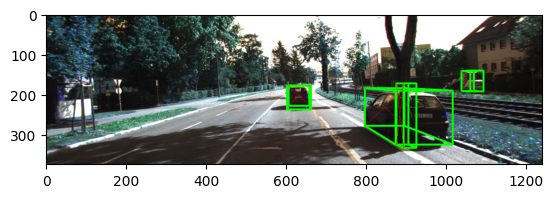

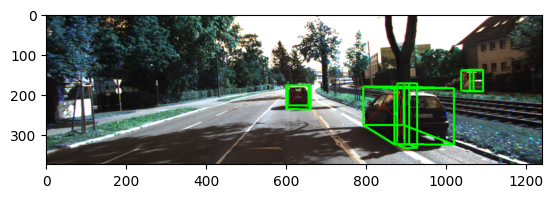

car
GT [2.89 0.72 0.88] CALC [ 9.94  1.14 12.9 ]
car
GT [2.89       0.80500007 5.71      ] CALC [3.02 0.63 6.4 ]
car
GT [ 2.15        0.91499996 14.83      ] CALC [ 2.13  0.91 14.81]
cyclist
GT [-4.61  0.98 18.42] CALC [-4.56  0.95 18.17]
car
GT [-5.87       1.1800001 17.52     ] CALC [-5.67  1.08 16.91]
car
GT [ 1.08        0.79499996 21.88      ] CALC [ 1.07  0.76 21.95]
car
GT [-1.31   1.125 33.9  ] CALC [-1.35  1.11 34.41]
car
GT [-9.6    1.315 38.84 ] CALC [-9.72  1.27 39.1 ]
car
GT [-3.48   1.165 43.72 ] CALC [-3.51  1.13 43.98]
pedestrian
GT [-13.17   0.97  47.98] CALC [-12.93   0.91  46.9 ]
pedestrian
GT [-13.69        1.2600001  47.83     ] CALC [-14.33   1.29  50.09]
cyclist
GT [-4.18        0.93499994 20.5       ] CALC [-3.8   0.91 18.52]
dontcare


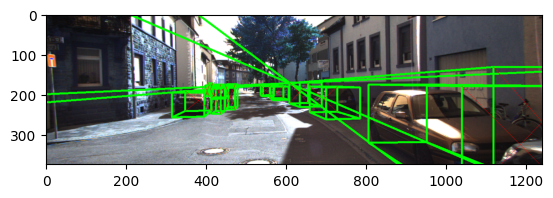

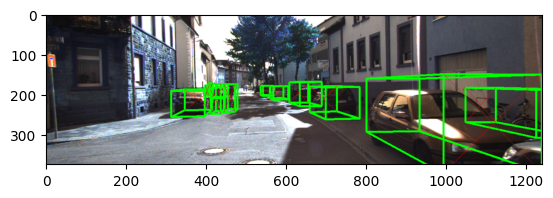

car
GT [-3.68  1.22 45.59] CALC [-3.66  1.14 44.97]


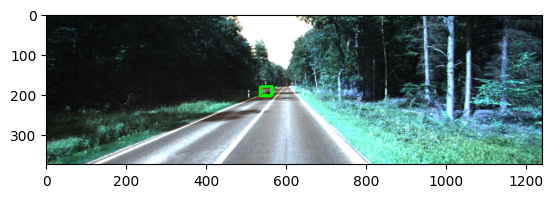

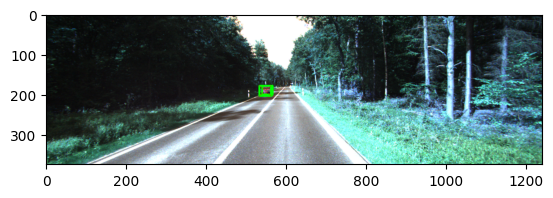

truck
GT [-0.65   1.435 63.37 ] CALC [-0.83  1.3  62.61]
cyclist
GT [ 4.27        0.87999994 17.48      ] CALC [ 4.23  0.85 17.43]
car
GT [-16.83    2.405  53.36 ] CALC [-16.84   2.34  53.25]
dontcare
dontcare


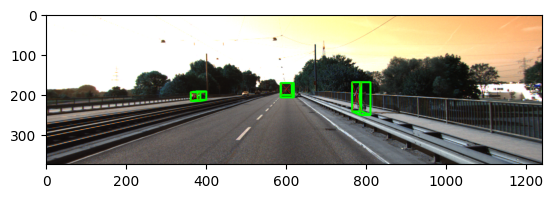

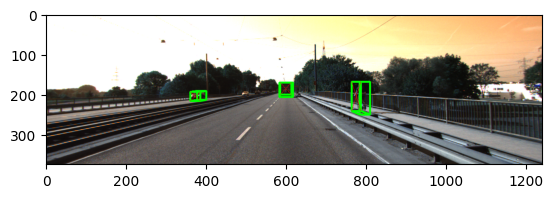

car
GT [ 0.2        1.1700001 45.16     ] CALC [ 0.15  1.13 45.16]
truck
GT [ 4.65        0.72500014 73.63      ] CALC [ 4.62  0.63 74.66]
misc
GT [-16.6          0.96500015  37.39      ] CALC [-16.3    0.9   36.65]
car
GT [-12.69        1.4300001  25.       ] CALC [-12.65   1.41  24.87]
van
GT [-13.31        1.5649999  71.85     ] CALC [-12.86   1.45  69.12]
dontcare
dontcare


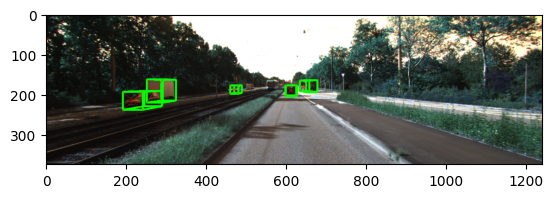

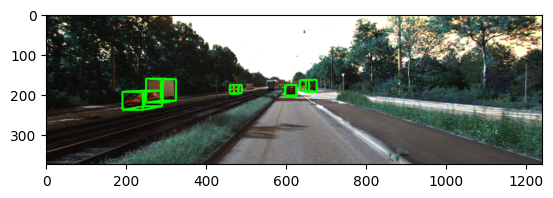

car
GT [-5.8   1.22 24.1 ] CALC [-5.73  1.14 23.69]
misc
GT [-3.41   1.065 39.96 ] CALC [-3.29  1.04 38.32]
car
GT [-3.4   1.28 56.03] CALC [-3.25  1.26 52.92]
dontcare
dontcare
dontcare


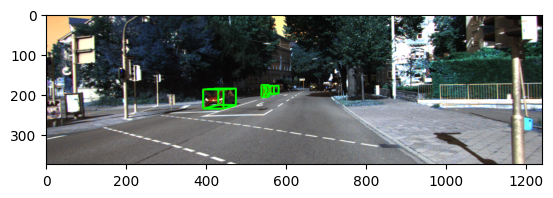

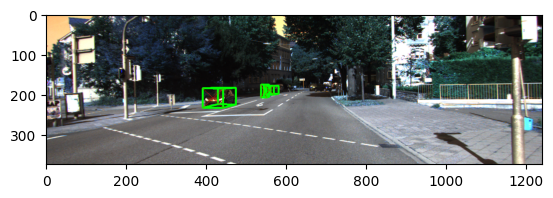

pedestrian
GT [-6.68        0.39000005 15.03      ] CALC [-7.37  0.4  16.4 ]
pedestrian
GT [-6.47        0.38999993 15.68      ] CALC [-7.57  0.42 17.74]
van
GT [ 2.97        0.33999997 20.52      ] CALC [ 2.92  0.33 20.35]
car
GT [36.38        0.28500003 48.57      ] CALC [35.53  0.26 47.51]


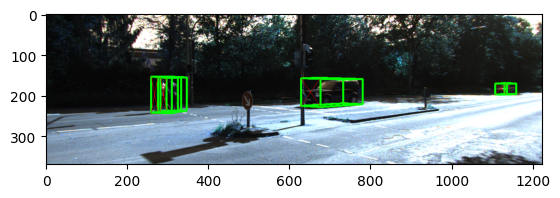

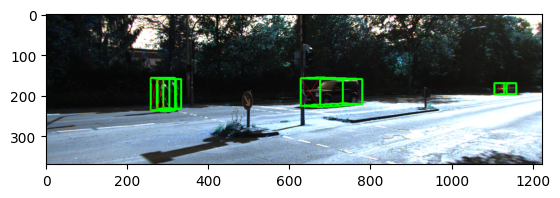

pedestrian
GT [ 5.95  1.13 38.94] CALC [ 6.12  1.14 40.05]
misc
GT [-20.92        1.4100001  29.2      ] CALC [-21.01   1.41  29.3 ]
car
GT [-13.92        1.3700001  27.3      ] CALC [-13.89   1.36  27.18]
car
GT [-16.83    1.425  29.78 ] CALC [-16.54   1.33  29.26]
car
GT [-14.12   1.56  49.73] CALC [-13.71   1.45  48.12]
dontcare
dontcare
dontcare
dontcare
dontcare


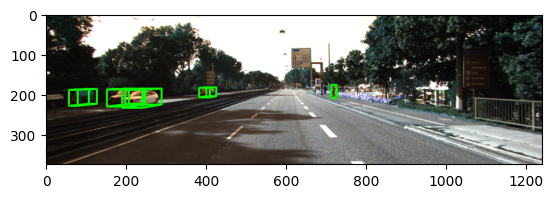

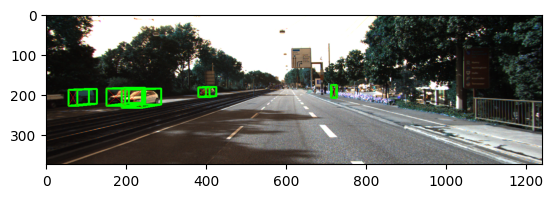

car
GT [-5.77  1.01  6.35] CALC [-8.41  1.92 12.69]
pedestrian
GT [-7.38  0.91 21.55] CALC [-7.48  0.89 21.73]
car
GT [ 1.97  0.84 12.66] CALC [ 1.89  0.82 12.48]


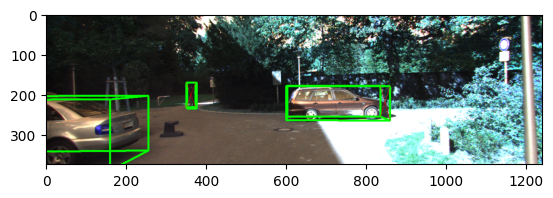

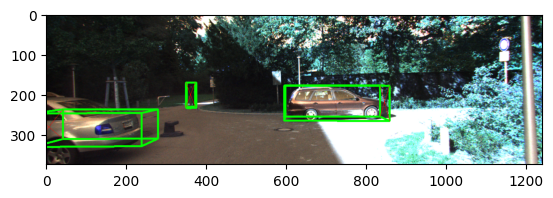

pedestrian
GT [2.7        0.53000003 7.63      ] CALC [2.97 0.58 8.37]


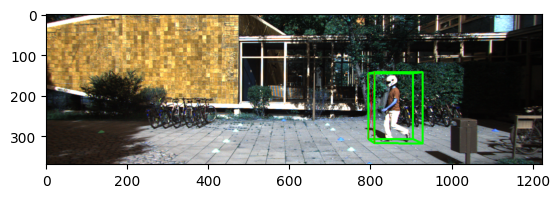

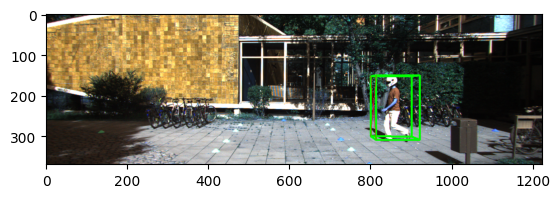

In [45]:
from torch_lib.KITTI_Dataset import Object3d, FrameCalibrationData
from library.ron_utils import *
import glob, os, re
import cv2
import matplotlib.pyplot as plt
# weights/0830_Adam/Elan_BL_B4_N1_50.pkl
# IVA_scenario_data_NCTU/day-rain

rons_folder = '0830_Adam/Elan_3d_box/BL_B4_N1'

cam_to_img = np.array([
            [1.418667e+03, 0.000e+00, 6.4e+02, 0],
            [0.000e+00, 1.418867e+03, 3.6e+02, 0],
            [0.000e+00, 000e+00, 1.0e+00, 0] ])

#images = sorted(glob.glob('Elan_3d_box/image_2/*.png'))
#labels = sorted(glob.glob('Elan_3d_box/renew_label/*.txt'))
images = sorted(glob.glob('Kitti/training/image_2/*.png'))
labels = sorted(glob.glob('Kitti/training/label_2/*.txt'))
calibs = sorted(glob.glob('Kitti/training/calib/00????.txt'))

for i in range(200,210):#len(zzys_labels)):
    objects = [Object3d(line) for line in open(labels[i]).readlines()]
    img = cv2.imread(images[i])
    calc_img = np.copy(img)
    cam_to_img = FrameCalibrationData(calibs[i]).p2
    for obj in objects:
        
        class_ = obj.cls_type
        truncation = obj.truncation
        occlusion = obj.occlusion
        print(class_)
        if class_.lower() == 'dontcare':
            continue
        alpha = obj.alpha
        ry = obj.ry
        gt_box2d = obj.box2d
        dim = obj.dim
        loc = obj.pos
        loc[1] -= dim[0]/2
        theta_ray = calc_theta_ray(img.shape[1], gt_box2d, cam_to_img)
        #cv2.rectangle(img, (obj.box2d[0], obj.box2d[1]), (obj.box2d[2], obj.box2d[3]), (255,0,0), 2)
        gt_prj_box = loc3d_2_box2d(ry, loc, dim, cam_to_img)
        gt_prj_box[0] += 27
        gt_prj_box[2] += 27 #elan data right shift 27
        calc_loc, _ = calc_location(dim, cam_to_img, gt_box2d, alpha, theta_ray)
        calc_loc = np.round(calc_loc, 2)
        calc_prj_box = loc3d_2_box2d(ry, calc_loc, dim, cam_to_img)
        #calc_prj_box[0] += 27
        #calc_prj_box[2] += 27 #elan data right shift 27
        print('GT', loc, 'CALC', calc_loc)

        #cv2.rectangle(img, (obj.box2d[0], obj.box2d[1]), (obj.box2d[2], obj.box2d[3]), (255,0,0), 2)
        #cv2.rectangle(img, (gt_prj_box[0], gt_prj_box[1]), (gt_prj_box[2], gt_prj_box[3]), (0,0,255), 2)
        #cv2.rectangle(img, (calc_prj_box[0], calc_prj_box[1]), (calc_prj_box[2], calc_prj_box[3]), (0,255,0), 2)
        #print(calc_IoU_2d(gt_prj_box, calc_prj_box))
        #elan_plot_3d_box(img, cam_to_img, ry, dim, calc_loc)
        plot_3d_box(img, cam_to_img, ry, dim, loc)
        plot_3d_box(calc_img, cam_to_img, ry, dim, calc_loc)

    plt.imshow(img)
    plt.show()
    plt.imshow(calc_img)
    plt.show()


In [65]:
from torch_lib.ELAN_Dataset_new import *

cfg = {'path':'Elan_3d_box',
        'class_list':['car'], 'diff_list': [1, 2], #0:DontCare, 1:Easy, 2:Moderate, 3:Hard, 4:Unknown
        'bins': 4, 'cond':False, 'group':False, 'network':0}


ELAN_Dataset()

-->name: features.0.weight -->grad_requirs: True
-->name: features.0.bias -->grad_requirs: True
-->name: features.1.weight -->grad_requirs: True
-->name: features.1.bias -->grad_requirs: True
-->name: features.3.weight -->grad_requirs: True
-->name: features.3.bias -->grad_requirs: True
-->name: features.4.weight -->grad_requirs: True
-->name: features.4.bias -->grad_requirs: True
-->name: features.7.weight -->grad_requirs: True
-->name: features.7.bias -->grad_requirs: True
-->name: features.8.weight -->grad_requirs: True
-->name: features.8.bias -->grad_requirs: True
-->name: features.10.weight -->grad_requirs: True
-->name: features.10.bias -->grad_requirs: True
-->name: features.11.weight -->grad_requirs: True
-->name: features.11.bias -->grad_requirs: True
-->name: features.14.weight -->grad_requirs: True
-->name: features.14.bias -->grad_requirs: True
-->name: features.15.weight -->grad_requirs: True
-->name: features.15.bias -->grad_requirs: True
-->name: features.17.weight -->g

In [62]:
parms.grad==None

True